In [5]:
import sys
import numpy as np
import string
import re
import unidecode
import pandas as pd
from numpy.linalg import norm
from sklearn.feature_extraction.text import CountVectorizer

# Data Loading

In [6]:
from bs4 import BeautifulSoup

def get_data(file, root_needed, tags):
    with open(file, 'r') as f:
        if root_needed:
            data = "<fake_root>\n"
            data += f.read()
            data += "\n</fake_root>"    
            Bs_data = BeautifulSoup(data, "xml")
        else:
            data = f.read()
            Bs_data = BeautifulSoup(data, "xml")
    
    result = []
    first_tag = tags[0]
    output = Bs_data.find_all(first_tag)
    for item in output:
        sub_list = []
        sub_list.append(item.text)
        result.append(sub_list)
        
    
    if len(tags) > 1:
        master_list = []
        len_tags = len(tags)
        total_rows = len(result)
        
        for i in range(1,len_tags):
            tag = tags[i]
            output = Bs_data.find_all(tag)
            idx = 0
            for item in output:
                result[idx].append(item.text)
                idx+=1
            
        
    return result

# Data Preprocessing

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import re
from bs4 import BeautifulSoup


def do_pre_process(content:str):
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    
    text = BeautifulSoup(content, "html.parser").get_text() 
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    txt_to_words = word_tokenize(text)
    txt_to_words = [word for word in txt_to_words if word not in stopwords.words("english")]
    txt_to_words = [lemmatizer.lemmatize(word) for word in txt_to_words]
    txt_to_words = [stemmer.stem(word) for word in txt_to_words]
    words_to_txt = ' '.join(txt_to_words)
                
    return words_to_txt

[nltk_data] Downloading package punkt to /Users/kpmanoj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kpmanoj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kpmanoj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Indexing

In [8]:
def term_frequency(docs_to_vectorize):
    vectorizer = CountVectorizer()
    documents_vectorized = vectorizer.fit_transform(docs_to_vectorize).toarray()
    vocabulary = vectorizer.get_feature_names()
    
    term_freq_matrix = pd.DataFrame(documents_vectorized, columns = vocabulary)
    return term_freq_matrix

def get_tf_idf_vec(term_freq_matrix):
    N = term_freq_matrix.shape[0] # Total number of documents.
    dfs = (term_freq_matrix > 0).sum(axis = 0) # Count of frequency.
    idfs = np.log(N/dfs)
    tf_idf_matrix = np.array(term_freq_matrix * idfs) # TF-IDF matrix.
    
    return tf_idf_matrix, idfs

def query_tf(qry_to_vec, doc_vocab, idf):
    q_vectorizer = CountVectorizer()
    q = q_vectorizer.fit_transform([qry_to_vec]).toarray()
    qry_vocabulary = q_vectorizer.get_feature_names()
    qry_tf_vector = np.array([])
    for item in doc_vocab.columns:
        if item in qry_vocabulary:
            qry_tf_vector = np.append(qry_tf_vector,1)
        else: 
            qry_tf_vector = np.append(qry_tf_vector,0)
            
    q_tf_idf_vector = (qry_tf_vector * idf).values
    
    return q_tf_idf_vector, qry_vocabulary

# IR Modelling (VSM, BM25)

In [9]:
def cosine_sim(x, y):
    cos_sim = np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))
    return cos_sim

def VSM(q_tf_idf_vect, doc_tf_idf_matrix):
    VSM_scores = []
    for d in doc_tf_idf_matrix:
        VSM_scores.append(cosine_sim(d, q_tf_idf_vect))
    return VSM_scores


def BM25_matrix_fn(BM25_matrix, q_vocabulary):
    q_vocabulary_in_docs = [term for term in q_vocabulary   
                            if term in BM25_matrix.columns] 
    BM25_scores = BM25_matrix[q_vocabulary_in_docs].sum(axis = 1)

    return BM25_scores

def BM25(k1, b, term_freq_matrix,idfs,q_vocabulary):
    dl = term_freq_matrix.sum(axis=1).tolist() # Document length.
    avgdl = np.mean(dl) # Mean document length.
    N = term_freq_matrix.shape[0]

    # Applying the BM25 formula:
    numerator = np.array(term_freq_matrix * (k1 + 1))
    denominator = np.array(term_freq_matrix) \
                  + np.array(k1 * ((1 - b) + (b * (dl / avgdl)))).reshape(N,1)
    BM25_matrix = (numerator / denominator) * np.array(idfs)
    BM25_matrix = pd.DataFrame(BM25_matrix, columns = term_freq_matrix.columns)
    
    scores = BM25_matrix_fn(BM25_matrix, q_vocabulary)
    return scores
    
def write_file(path:str, ranked_list:list):
    
    with open(path, 'w') as fp:
        for item in ranked_list:
            for ele in item:
                fp.write(f"{ele}\t")
            fp.write("\n")

    fp.close()
    
    return


# Ranking

In [10]:
def search_engine(docs:list, 
           qrys:list, 
           model:str="VSM", 
           top_n:int=10):
    def sort(results:list):
        return(sorted(results, key = lambda x: x[3], reverse=True))  
    
    doc_texts = [do_pre_process(doc[2]) for doc in docs]
    qry_texts = [do_pre_process(qry[1]) for qry in qrys]
    
    doc_ids = [int(doc[0]) for doc in docs]
    qry_ids = [int(qry[0]) for qry in qrys]
    
    doc_to_vec = term_frequency(doc_texts)
    doc_tf_idf_mrx, idf = get_tf_idf_vec(doc_to_vec)
    
    shape_of_df = (len(doc_to_vec.index), len(doc_to_vec.columns))
    
    assert shape_of_df == doc_tf_idf_mrx.shape
    
    doc_info_ranked = []
    iteration = 0
 
    for i in range(len(qry_ids)):
        qry_id = qry_ids[i]
        qry_text = qry_texts[i]
        
        q_tf_idf_vec, q_voc = query_tf(qry_text, doc_to_vec, idf)
        
        if model == "VSM":
            scores = VSM(q_tf_idf_vec, doc_tf_idf_mrx)
        if model == "BM25":
            scores = BM25(2, 0.75, doc_to_vec,idf,q_voc) # Values for parameters k and b are chosen based on recommendations in lecture materals
            
        run_id = 0
        sub_list = []
        for (d,n,s) in zip(doc_texts, range(len(doc_ids)), scores):
            iteration+=1
            run_id += 1
            sub_list.append([qry_id, iteration, doc_ids[n], scores[n], run_id])

        sorted_list = sort(sub_list)
        sorted_list = sorted_list[:(top_n)]

        sorted_list1 = []
        rank = 1
        for i in range(top_n):

            item = sorted_list[i]
            item.insert(3,rank)
            rank+=1
            sorted_list1.append(item)

        for item in sorted_list1:
            doc_info_ranked.append(item)
            
    doc_to_print = doc_info_ranked[:10]
        
    print("Sample txt file to print")
    print(f'QID\t<iter>\tDocID\t<rank>\t{model}Score\t\t<run_id>')
        
    for item in doc_to_print:
        list_to_print = [str(w) for w in item]
        print('\t'.join(list_to_print))
             
    return doc_info_ranked

In [11]:
import os

def main():
    
    Vsm_file_name = "ResultsVSM.txt"
    bm25_file_name = "ResultsBM25.txt"
    curr_dir_path = os.getcwd()
    final_path_vsm = os.path.join(curr_dir_path, Vsm_file_name)
    final_path_bm25 = os.path.join(curr_dir_path, bm25_file_name)
    
    documents = get_data('cran.all.1400.xml', 1 , ['docno','title','text'])
    queries = get_data('cran.qry.xml',0, ['num','title'])
    
    results_vsm = search_engine(documents, queries, "VSM", 100)
    results_bm25 = search_engine(documents, queries, "BM25", 100)
    
    write_file(final_path_vsm, results_vsm)
    write_file(final_path_bm25, results_bm25)
    
main()

<ipython-input-9-cfd3f4c02c39>:2: RuntimeWarning: invalid value encountered in double_scalars
  cos_sim = np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))


Sample txt file to print
QID	<iter>	DocID	<rank>	VSMScore		<run_id>
1	51	51	1	0.2732997203987599	51
1	184	184	2	0.2423519383135303	184
1	12	12	3	0.2199770970786302	12
1	359	359	4	0.19718798836720966	359
1	746	746	5	0.18877604723401475	746
1	56	56	6	0.16338803624451917	56
1	665	665	7	0.15879099094312427	665
1	13	13	8	0.14432588580353264	13
1	435	435	9	0.13223795298404534	435
1	486	486	10	0.13068845916810296	486
Sample txt file to print
QID	<iter>	DocID	<rank>	BM25Score		<run_id>
1	51	51	1	25.05507180936116	51
1	486	486	2	21.98695817024441	486
1	12	12	3	20.72787817315684	12
1	184	184	4	19.242587466122195	184
1	878	878	5	18.257708416426983	878
1	573	573	6	16.77241514110718	573
1	665	665	7	14.923395093430525	665
1	746	746	8	13.7557520390895	746
1	944	944	9	13.462667853243094	944
1	141	141	10	13.353771708377367	141


# Evaluation (data visualization)

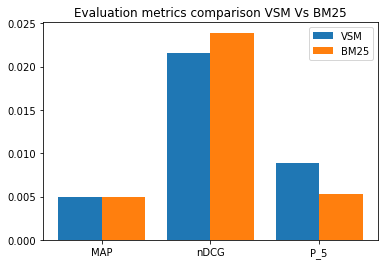

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# Values retrived from running dyn_eval on the VSM results and BM25 results
X = ['MAP','nDCG','P_5']
VSM_data = [0.0050,0.0216,0.0089] 
BM25_data = [0.0050,0.0239,0.0053]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, VSM_data, 0.4, label = 'VSM')
plt.bar(X_axis + 0.2, BM25_data, 0.4, label = 'BM25')

plt.xticks(X_axis, X)

plt.title("Evaluation metrics comparison VSM Vs BM25")
plt.legend()
plt.show()
